In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# More readable exceptions.
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [3]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [4]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [5]:
original_training_data = original_training_data.fillna('')
print(original_training_data.isnull().sum())

id         0
subject    0
email      0
spam       0
dtype: int64


In [6]:
# This creates a 90/10 train-validation split on our labeled data.

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

train = train.reset_index(drop = True)

In [7]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, p) where 
        n is the number of texts and p is the number of words.
    """
    indicator_array = []
    texts = np.array(texts)
    words = np.array(words)
    for i in texts:
        col = []
        for j in words:
            col.append(int(j in i))
        indicator_array.append(col)
    return np.array(indicator_array)

words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

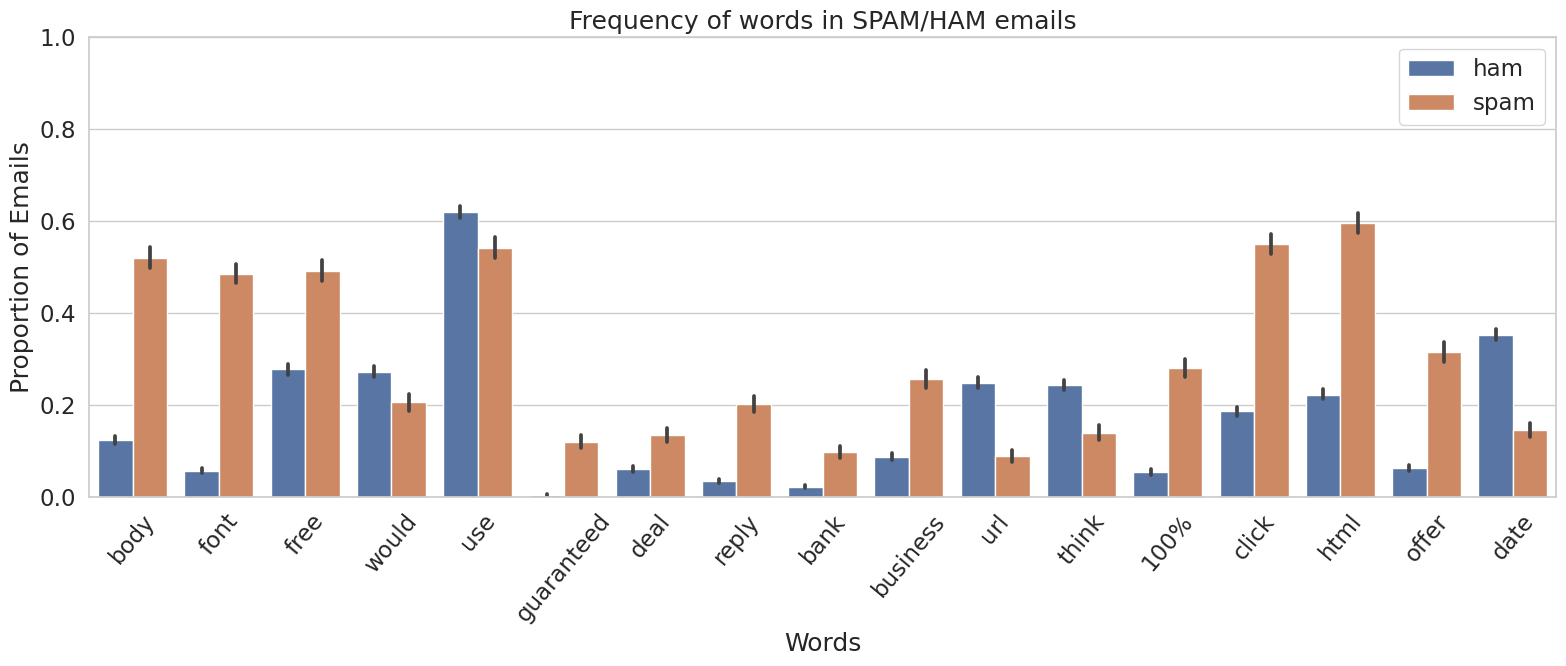

In [8]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
plt.figure(figsize=(16,7))
tr_set = words_in_texts(['body', 'font', 'free', 'would', 'use',
         'guaranteed', 'deal', 'reply', 'bank', 'business', 'url',
          'think', '100%', 'click', 'html', 'offer', 'date'], train['email'])
tr_set = pd.DataFrame(tr_set)
tr_set['type'] = train['spam']
tr_set = tr_set.replace({'type': {0: 'ham', 1: 'spam'}})
tr_set = tr_set.melt('type')
sns.barplot(data = tr_set, x = 'variable', y = 'value', hue = 'type').set(xticklabels=['body', 'font', 'free', 'would', 'use',
         'guaranteed', 'deal', 'reply', 'bank', 'business', 'url',
          'think', '100%', 'click', 'html', 'offer', 'date'])
plt.ylim(0, 1)
plt.xticks(rotation=50)
plt.legend(loc='upper right')
plt.ylabel('Proportion of Emails')
plt.xlabel('Words')
plt.title('Frequency of words in SPAM/HAM emails')
plt.tight_layout()
plt.show()

In [9]:
def len_of_subject(texts):
    texts = texts.astype('string')
    texts = texts.fillna('')
    array = []
    for text in texts:
        array.append(len(text) < 30)
    
    return np.multiply(array, 1)



In [10]:
r = len_of_subject(original_training_data[original_training_data['spam'] == 0]['subject'])
t = len_of_subject(original_training_data[original_training_data['spam'] == 1]['subject'])
r
train['subject']

0                  Subject: Patch to enable/disable log\n
1             Subject: When an engineer flaps his wings\n
2       Subject: Re: [Razor-users] razor plugins for m...
3       Subject: NYTimes.com Article: Stop Those Press...
4       Subject: What's facing FBI's new CIO? (Tech Up...
                              ...                        
7508    Subject: [Spambayes] understanding high false ...
7509          Subject: Reach millions on the internet!!\n
7510                          Subject: Facts about sex.\n
7511    Subject: Re: Zoot apt/openssh & new DVD playin...
7512    Subject: Re: Internet radio - example from a c...
Name: subject, Length: 7513, dtype: object

In [11]:
from sklearn.linear_model import LogisticRegression
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!
#some_words = ['body', 'font', 'click', 'please', 'head', 'html', 'offer']
some_words = ['body', 'font', 'free', 'would', 'use',
         'guaranteed', 'deal', 'reply', 'bank', 'business', 'url',
          'think', '100%', 'click', 'html', 'offer', 'date']

X_train = np.c_[words_in_texts(some_words, train['email']), len_of_subject(train['subject'])]
#X_train = pd.DataFrame(X_train, columns=['body', 'font', 'click', 'please', 'head', 'html', 'offer', 'email_length', 'subject_length'])
X_train = pd.DataFrame(X_train, columns=['body', 'font', 'free', 'would', 'use',
         'guaranteed', 'deal', 'reply', 'bank', 'business', 'url',
          'think', '100%', 'click', 'html', 'offer', 'date', 'subject_length'])

Y_train = np.array(train['spam'])


lr = LogisticRegression(
        fit_intercept=True)

model = lr.fit(X_train, Y_train)

training_accuracy = np.mean(Y_train == lr.predict(X_train))
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.8846000266205244


Text(0.5, 1.0, 'Feature Correlation Heatmap')

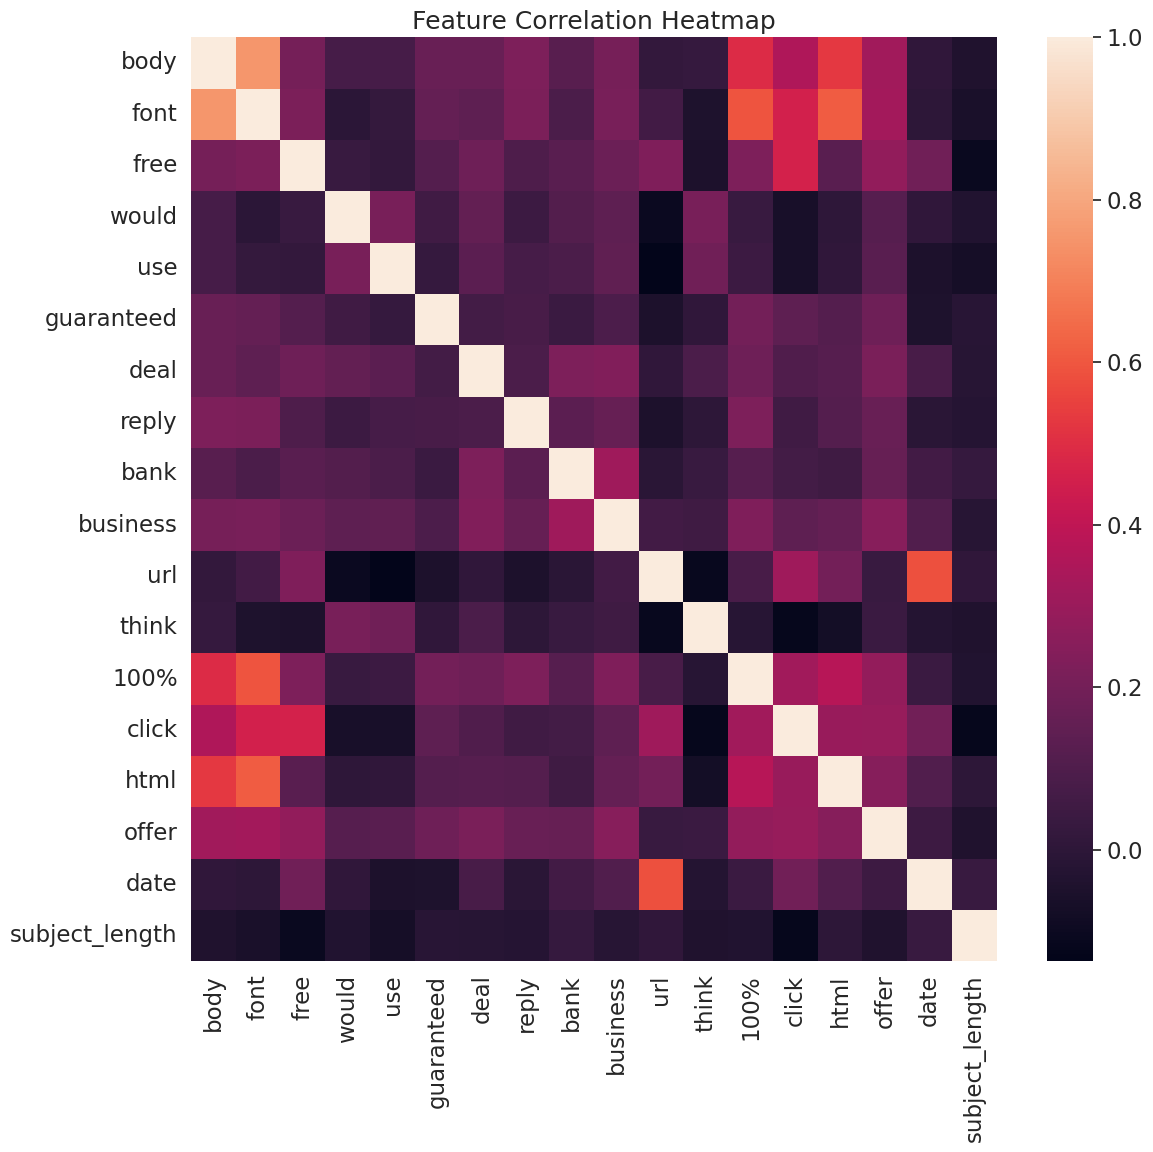

In [12]:
plt.figure(figsize = (13,12))
sns.heatmap(X_train.corr())
plt.title("Feature Correlation Heatmap")

Text(0.5, 1.0, 'ROC Curve')

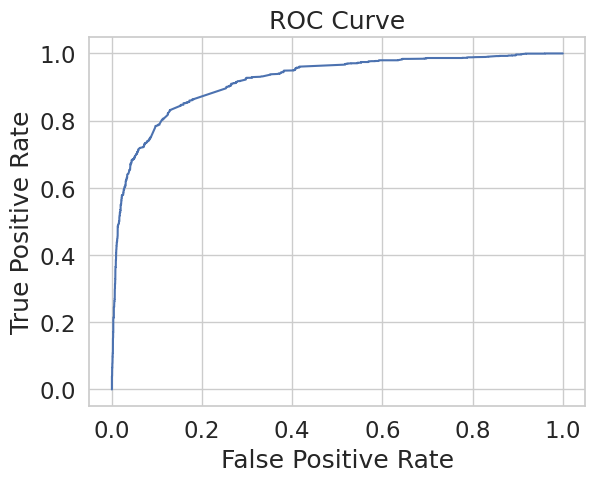

In [13]:
from sklearn.metrics import roc_curve

prob = lr.predict_proba(X_train)[:, 1]
false_p, true_p, thresh = roc_curve(Y_train, prob)

plt.plot(false_p, true_p)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [14]:
X_val = np.c_[words_in_texts(some_words, val['email']), len_of_subject(val['subject'])]

X_val = pd.DataFrame(X_val, columns=['body', 'font', 'free', 'would', 'use',
         'guaranteed', 'deal', 'reply', 'bank', 'business', 'url',
          'think', '100%', 'click', 'html', 'offer', 'date', 'subject_length'])

In [15]:
Y_val = np.array(val['spam'])

In [16]:
test_predictions = lr.predict(X_val)

In [17]:
test_accuracy = np.mean(Y_val == test_predictions)
test_accuracy

0.9041916167664671